In [1]:
# Author: Andi Sama
# Organization: Sinergi Wahana Gemilang
#   a Value Added Distributor in Jakarta, Indonesia
# Created: June 18, 2018
# Last modified:
#   - June 19, 2018
#     * Add a few more information during training by modifying code in network_asm.py
#       (% on classification rate & elapsed time per epoch + total elapsed time for all epochs)
#     * Add a few more information during training by modifying code in mnist_loader_asm.py
#       (loaded data sizes)
#   - June 21, 2018
#     * Apply cross-entropy on cost function (previously: use quadratic cost) to improve accuracy
#     * Apply Mini-batch gradient descent (previously: just Stochastic Gradient Descent)
#     * Add monitor_elapsed_time flag in network2_asm.py
#     * Draw plot for training cost, evaluation cost against # of epoch
#     * Use Gaussian distributions with mean 0 and standard deviation 1 over the square root
#       of the number of weights connecting to the same neuron for network initialization
#       (previously: Gaussian distribution without square root)
#   - June 23, 2018
#     * Use regularization - lambda 
#     * Visualization of mnist dataset
#   - June 24, 2018
#       Add predict() function use existing function load() network after save()
#       => vanilla version done
#   - June 24, 2018
#     * use mnist testing dataset to predict (now still using training data)
#   - June 25-26, 2018
#     * migrate to IBM Watson Studio (on cloud)
#       - upload all files to IBM object storage
#       - get all files to working directory by using IBM boto3 api
#       - convert code from python 2.7 to 3.5 (print function, cPickle handler, xrange)
#   - June 28, 2018
#     retrain with lambda = 0 (no regularization, for article - for SWG Insights Q4 2018)
# Topic: Beginning Deep Learning (computer vision)
# Purpose: Recognizing handwritten digits 0-9 in 3 steps
#   - 1. Prepare datasets (MNIST, modified nist database)
#   - 2. Train, Validate on datasets to generate deep learning model (architecture, weights)
#   - 3. Predict new data based on generated model with testing data 
# Type of Neural Network: Supervised Learning with shallow neural network
#   Dataset: mnist
#     - original training dataset (60,000): handwritten digits from 250 persons (2 groups)
#       further then divided to be 50,000 for training dataset and 10,000 for validation dataset
#     - testing dataset (10,000): handwritten digits from another set of 250 persons (2 groups)
# Reference:
#   - Michael A. Nielsen, "Neural Network & Deep Learning",
#     Determination Press, 2015 http://neuralnetworksanddeeplearning.com 
#     Original code from the book is at https://github.com/mnielsen/neural-networks-and-deep-learning
#   - various references from stackoverflow, github, and related library documentations etc

In [2]:
# GET ALL REQUIRED FILES to working directory by using IBM boto3 api
# Just need to do this once, comment afterward
#
import sys
import types
import pandas as pd # dataframe manipulations
from botocore.client import Config # to access IBM Object Storage
import ibm_boto3 # to access IBM Object Storage

# LOAD required libraries
import matplotlib.pyplot as plt # graphic related things
import numpy as np # matrix manipulations
import math # math functions

In [3]:
# The code was removed by DSX for sharing.

In [4]:
# Above cell is hidden for publishing... get your own key from IBM Watson Studio on IBM cloud to fill the following
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# replace "your IBM API Key" with your generated key
# s3 = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='your IBM API Key',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

In [5]:
# replace the following "mybucket" with your generated bucket
mybucket='doctorofcomputerscience-donotdelete-pr-e1zj6xtk1pjpth'
# 1. get mnist dataset
with open('mnist.pkl.gz', 'wb') as data:
    s3.download_fileobj(mybucket, 'mnist.pkl.gz', data)
# 2. get pyton library for loading mnist dataset
with open('mnist_loader_asm_py3.py', 'wb') as data:
    s3.download_fileobj(mybucket, 'mnist_loader_asm_py3.py', data)
# 3. get pyton library for training & prediction
with open('network2_asm_b_py3.py', 'wb') as data:
    s3.download_fileobj(mybucket, 'network2_asm_b_py3.py', data)
# file for testing to predict(), get pre-trained network (without retraining)
# 2 hidden layers at 30 neurons each, lr=0.15, batch size=32, no regularization
# result: train cost: 0.0609736142951, eval cost: 0.229741976137, train acc: 99.416 %, eval acc: 96.89 %
# June 28 2018: Total time for 50 Epochs are: 681.4261889457703 seconds on IBM Cloud (1vCPU 4 GB RAM)
with open('2018624223944_asm_Trained_NN', 'wb') as data:
    s3.download_fileobj(mybucket, '2018628165028_asm_Trained_NN', data)

In [6]:
# LOAD our specific libraries
import mnist_loader_asm_py3 # helper program for loading mnist data set
import network2_asm_b_py3 # helper program, neural network layers

In [7]:
#plot individual curve: training training/evaluation accuracy, training/evaluation cost
def plot_curve(xlabel, epoch, ylabel, loss):
    # epoch: total epoch, loss: list of lost values for all epochs
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    plt.plot(epochs,loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#compare training & evaluation accuracy / cost
def plot_curve_comparison(epoch, title, xlabel, data1, ylabel, data2):
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(epochs, data1, label=xlabel)
    ax.plot(epochs, data2, label=ylabel)
    plt.title(title)
    ax.legend()
    plt.show()

In [8]:
# ========================
# 1. LOAD Dataset (MNIST)
# ========================
# 1a. load mnist data using mnist_loader library
#   output is structured in such a way to fit and be ready for learning
#   each data is in 784x1 dimension, reshape to 28x28 pixels for viewing
#   each label is in 10x1 dimension,
#     extract array content with "1" in it to get the actual label ["0".."9"]
#

#training_data, validation_data, test_data = mnist_loader_asm_py3.load_data_wrapper()
zip_training_data, zip_validation_data, zip_test_data = mnist_loader_asm_py3.load_data_wrapper()

>> Training dataset (x, y)], length: 2 arrays.
  - 1st array (data, x) 28x28 pixels; total data: 50000 , length per data: 784
  - 2nd array (target label, y) [0..9]; total data: 50000
    sample dataset: 5


In [9]:
training_data = list(zip_training_data)
validation_data = list(zip_validation_data)
test_data = list(zip_test_data)

A few samples for the 28x28 pixels mnist digit dataset with its corresponding label


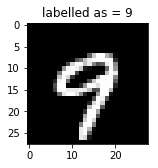

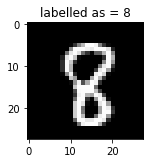

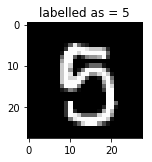

In [10]:
# 1b. just show a few sample digits with its corresponding labels
#
print("A few samples for the 28x28 pixels mnist digit dataset with its corresponding label")
row = 1
column = 3
np.random.shuffle(training_data) # just resuffle so we are showing different data when refreshed
for i in range(column):
    #get corresponding target label (y) "digit" from its vectorized format
    data = training_data[i][1]
    digit=0
    j=0
    for x in data:
        if int(x):
            digit=j
            break
        else:
            j=j+1
    #then, plot the image data 
    image = training_data[i][0].reshape(28, 28)   
    plt.subplot(row, column, i+1)  # subplot with size  
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    plt.title('labelled as = {0}'.format(digit))
    plt.axis('on')  # do not show axis value
    plt.tight_layout()  # automatic padding between subplots
    filename = "mnist_plot"+str(i)+".png"
    plt.savefig(filename)
    plt.show()

In [11]:
# ==================================================
# 2. TRAIN the Neural Network (SUPERVISED LEARNING)
# ==================================================
# 2a. first Create Neural Network Architecture (Input, Hidden Layers(), Output)
# setting up input layers for 28 x 28 pixels mnist input image size = 784 input neurons
# the following hyper-parameters are initially set
#
input_neurons  = 784  # 1st layer, input layer
hidden_neurons_1 = 30  # 2nd layer, 1st hidden layers
hidden_neurons_2 = 30  # 3rd layer, 2nd hidden layers
output_neurons = 10  # last layer, output layer
# then define the network (now: 1 hidden layers; can be multiple)
net = network2_asm_b_py3.Network([input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons],
    cost=network2_asm_b_py3.CrossEntropyCost)
net.default_weight_initializer()

In [12]:
# 2b. then, train the network (supervised learning)
#  generate weights, biases for all defined neural network hidden nodes
#
# prepare to run with additional hyper-parameters
lr = 0.15 # learning rate
mini_batch_size = 32
epoch = 50

# originally evaluation_data=test_data, changed to validation_data
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = \
    net.SGD(training_data, epoch, mini_batch_size, lr, evaluation_data=validation_data, lmbda=0,
    monitor_all=True)

>>> TRAINING STARTS...
Epoch 0  training complete
  train cost: 0.863242841516 , eval cost: 0.812249543772
  train acc: 87.81 % , eval acc: 88.98 %
  Epoch 0 completed in 7.707 seconds
Epoch 1  training complete
  train cost: 0.590506154094 , eval cost: 0.552447170477
  train acc: 91.294 % , eval acc: 91.89 %
  Epoch 1 completed in 7.097 seconds
Epoch 2  training complete
  train cost: 0.464163046495 , eval cost: 0.439446065111
  train acc: 93.044 % , eval acc: 93.59 %
  Epoch 2 completed in 7.57 seconds
Epoch 3  training complete
  train cost: 0.406169918374 , eval cost: 0.393168544893
  train acc: 93.872 % , eval acc: 94.02 %
  Epoch 3 completed in 6.961 seconds
Epoch 4  training complete
  train cost: 0.346982949951 , eval cost: 0.345848680077
  train acc: 94.856 % , eval acc: 94.96 %
  Epoch 4 completed in 7.438 seconds
Epoch 5  training complete
  train cost: 0.313478001371 , eval cost: 0.3214961602
  train acc: 95.438 % , eval acc: 95.38 %
  Epoch 5 completed in 7.738 seconds
Epo

In [13]:
# 2c. save the last trained network sizes, weights, biases, cost
#
# generate current time to be embedded in filename
import time
dt = time.localtime(time.time())
i=0
prefix = ""
while i<6:
    #print str(dt[i])
    prefix = prefix + str(dt[i])
    i=i+1
# embed the current time in file name
filename = prefix + "_asm_Trained_NN"
print("saving:", filename, "...")
net.save(filename)
print("done.")

saving: 20187234848_asm_Trained_NN ...
done.


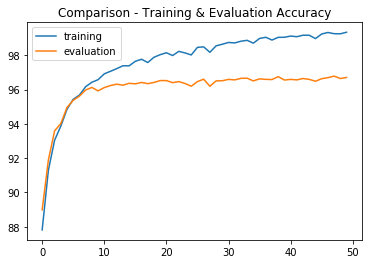

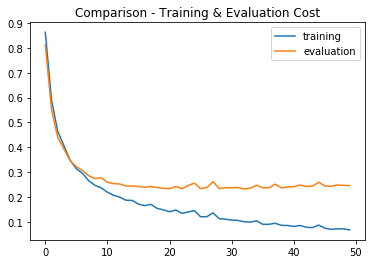

In [14]:
# 2d. plot comparison curve: accuracy & cost, for both training & evaluation
#
plot_curve_comparison(epoch, "Comparison - Training & Evaluation Accuracy", \
                      "training", training_accuracy, "evaluation", evaluation_accuracy)
plot_curve_comparison(epoch, "Comparison - Training & Evaluation Cost", \
                      "training", training_cost, "evaluation", evaluation_cost)

In [16]:
# 2.e drawing each curve one at a time (optional)
# #draw the curve - x for epoch and y for training cost
# plot_curve("epoch", epoch, "training loss", training_cost)
# #draw the curve - x for epoch and y for training accuracy
# plot_curve("epoch", epoch, "training accuracy", training_accuracy)
# #draw the curve - x for epoch and y for evaluation cost
# plot_curve("epoch", epoch, "evaluation loss", evaluation_cost)
# #draw the curve - x for epoch and y for evaluation accuracy
# plot_curve("epoch", epoch, "evaluation accuracy", evaluation_accuracy)

In [17]:
# 3. PREDICT New Image, based on saved network
#
# 3a. 1st, load the previously saved network 
# filename = "2018624223944_asm_Trained_NN"
mynet = network2_asm_b_py3.load(filename)

# 3b. define predict() function
def predict(network, x):        
    # feedforward to predict with trained weights, biases
    # network: trained neural network, x: new images
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    i=0
    for b, w in zip(network.biases, network.weights):
        i=i+1
        z = np.dot(w, activation)+b
        activation = sigmoid(z)
    #extracting highest confidence level from feed forward output
    digit=0
    confidence_level = 0.0
    threshold = 0.5
    j=0
    for i in activation: # output from the last layer
        if i >= threshold:
            digit=j
            confidence_level = i
            break
        else:
            j=j+1
    #print "predicted digit: {0}, confidence level: {1}%".format(digit, float(confidence_level)*100)
    conf_level = float(confidence_level*100)
    return digit, conf_level
            
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

A digit to predict from mnist testing dataset
label:8, predicted:8, conf_lvl:99.426%


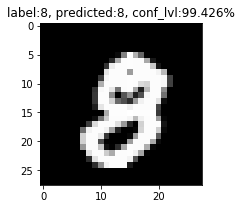

label:1, predicted:1, conf_lvl:99.98%


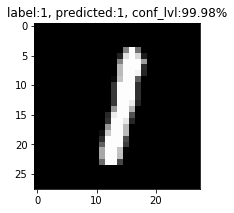

In [18]:
# 3c. then, predict 
# get a digit from new image
print("A digit to predict from mnist testing dataset")

row = 1
column = 2
# just resuffle so we are showing different data when refreshed, from mnist test dataset
np.random.shuffle(test_data) 
for i in range(column):
    #get corresponding target label (y) "digit" from its vectorized format
    digit_label = test_data[i][1]
    # finally, call predict() to predict a new image
    image = test_data[i][0] 
    digit_predicted, conf_level = predict(mynet, image)
    title = "label:{0}, predicted:{1}, conf_lvl:{2}%".format(digit_label, \
        digit_predicted, float(math.trunc(conf_level*1000))/1000)
    print(title)
    #then, plot the image data with title "labelled digit, predicted digit + its confidence level" 
    image = test_data[i][0].reshape(28, 28)   
    plt.subplot(row, column, 1)  # subplot with size  
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    #plt.title("label:{0}, predicted:{0}, conf_lvl:{1}%".format(digit_label, digit_predicted, conf_level))
    plt.title(title)
    plt.axis("on") # show axis value
    plt.tight_layout() # automatic padding between subplots
    plt.show()

In [19]:
# upload the trained data to IBM Object Storage
with open(filename, 'rb') as data:
    s3.upload_fileobj(data, mybucket, filename)

In [ ]:
!ls -al